In [9]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')
sns.set_context("talk")

In [3]:
from src.load_data import load_data

epoch_key = ('jaq', 1, 2) # animal, day, epoch

data = load_data(epoch_key)

11-Feb-20 21:59:49 Loading position information and linearizing...
11-Feb-20 22:10:15 Loading multiunits...


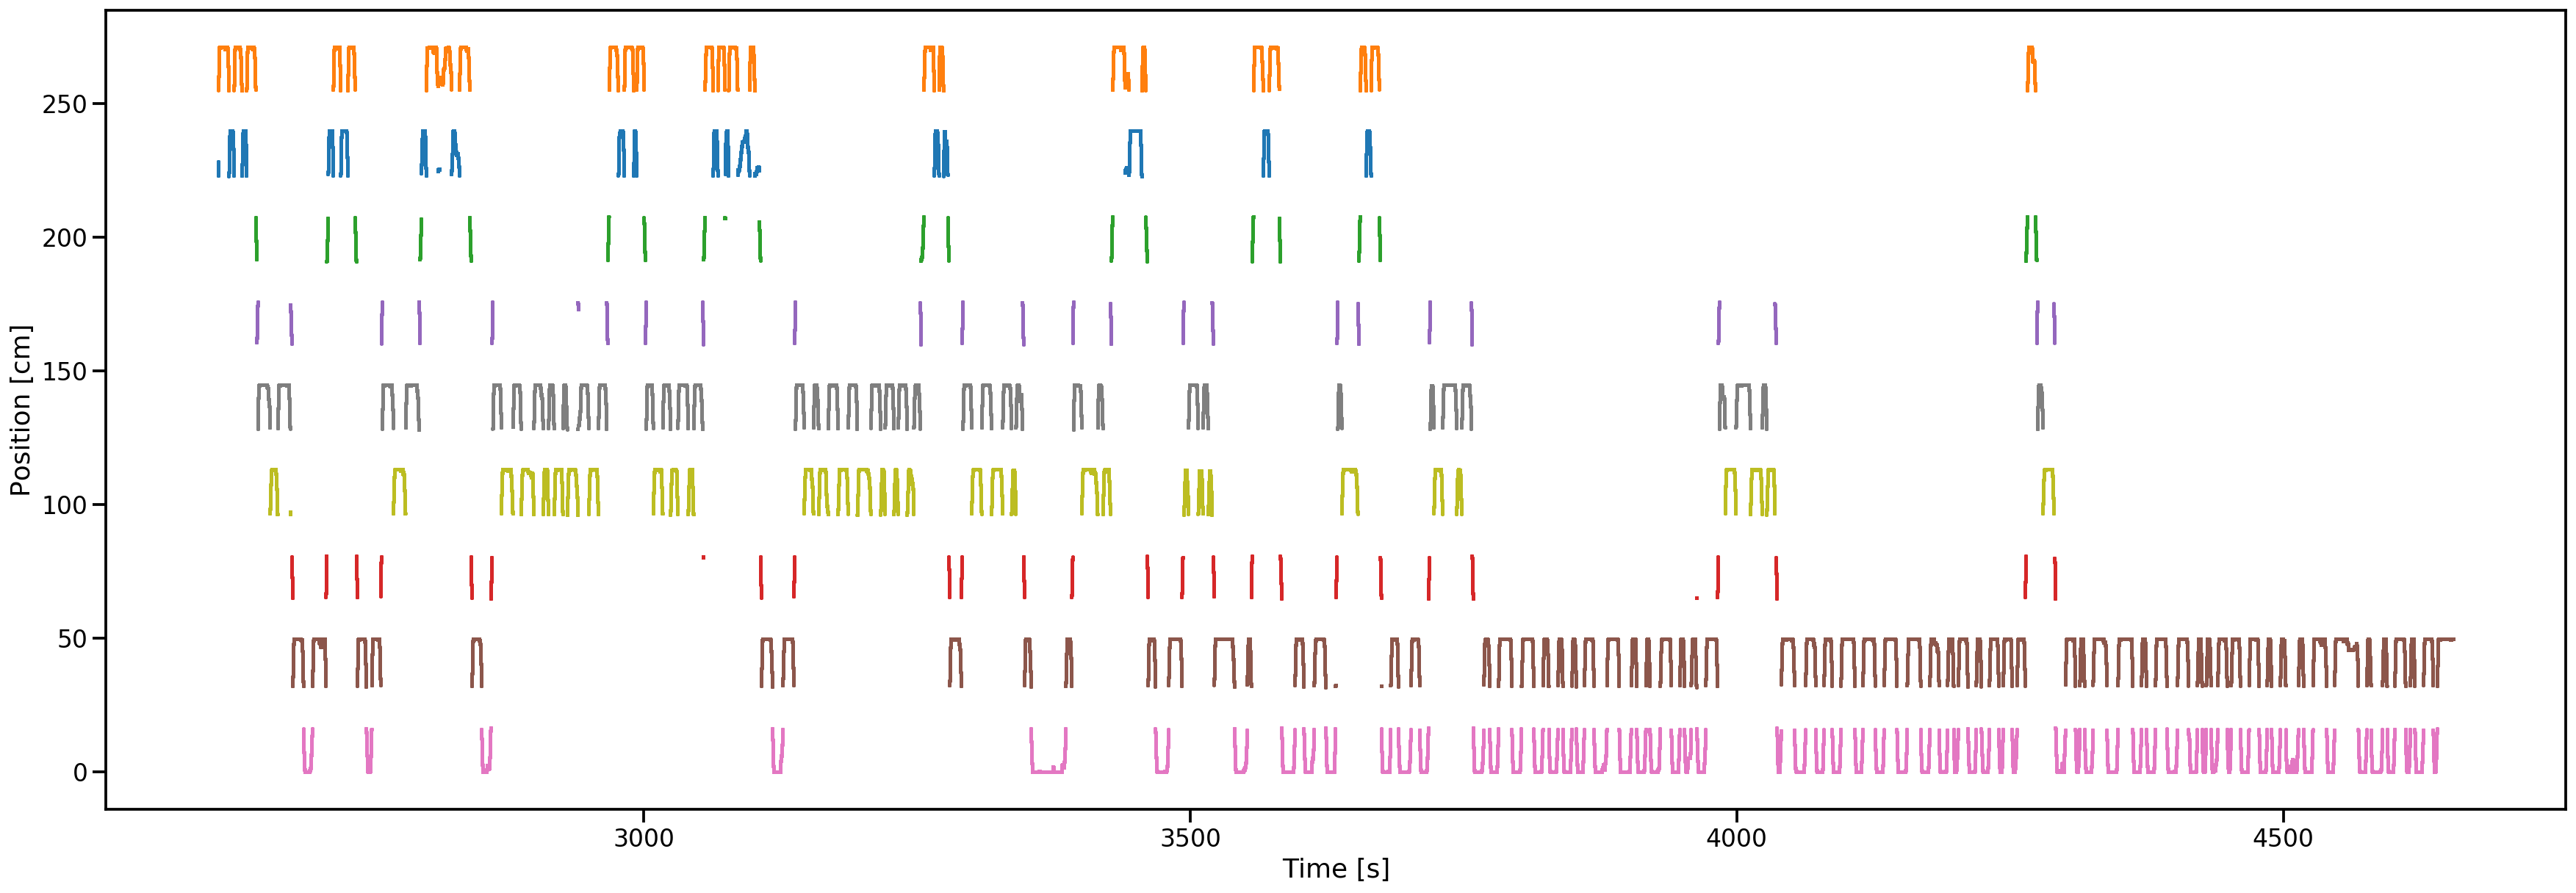

In [4]:
fig, ax = plt.subplots(figsize=(30, 10))

for edge_label, df in data['position_info'].groupby('track_segment_id'):
    ax.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=1)
    
ax.set_ylabel('Position [cm]')
ax.set_xlabel('Time [s]');

In [6]:
data["position_info"].to_xarray().to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_position_info.nc"
)

In [5]:
from src.parameters import EDGE_ORDER, EDGE_SPACING
from src.load_data import make_track_graph

track_graph, center_well_id = make_track_graph()
is_running = data["position_info"].speed > 4

## Continuous vs. Jump

In [9]:
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import classifier_parameters, discrete_state_transition

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

cv = KFold()
cv_classifier_clusterless_results = []

for fold_ind, (train, test) in tqdm(enumerate(cv.split(data["position_info"].index))):

    cv_classifier = ClusterlessClassifier(**classifier_parameters)

    cv_classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunits"].isel(time=train),
        is_training=is_running.iloc[train],
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )
    cv_classifier.discrete_state_transition_ = discrete_state_transition
    logging.info('Predicting posterior...')
    cv_classifier_clusterless_results.append(
        cv_classifier.predict(
            data["multiunits"].isel(time=test),
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
        )
    )

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...


KeyboardInterrupt: 

In [ ]:
cv_classifier_clusterless_results = xr.concat(
    cv_classifier_clusterless_results, dim="time"
)
cv_classifier_clusterless_results

In [ ]:
cv_classifier_clusterless_results.to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier_clusterless_results.nc"
)

In [11]:
from src.visualization import plot_classifier_time_slice

time_slice = slice(32500, 34500)

plot_classifier_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

## Local vs. Non-Local

In [ ]:
from replay_identification import ReplayDetector
from src.parameters import detector_parameters
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

cv = KFold()
cv_clusterless_results = []

for train, test in tqdm(cv.split(data["position_info"].index)):

    cv_detector = ReplayDetector(**detector_parameters)

    cv_detector.fit(
        is_ripple=data["is_ripple"].iloc[train],
        speed=data["position_info"].iloc[train].speed,
        position=data["position_info"].iloc[train].linear_position,
        multiunit=data["multiunit"].isel(time=train),
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )
    
    logging.info('Predicting posterior...')
    cv_clusterless_results.append(
        cv_detector.predict(
            speed=data["position_info"].iloc[test].speed,
            position=data["position_info"].iloc[test].linear_position,
            multiunit=data["multiunit"].isel(time=test),
            use_likelihoods=["multiunit"],
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
        )
    )

In [ ]:
cv_clusterless_results = xr.concat(cv_clusterless_results, dim="time")
cv_clusterless_results

In [ ]:
cv_clusterless_results.to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_clusterless_results.nc"
)

In [12]:
from src.visualization import plot_local_non_local_time_slice

time_slice = slice(32500, 34500)

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)